In [0]:
display(dbutils.fs.ls("/FileStore/tables/"))


path,name,size,modificationTime
dbfs:/FileStore/tables/ADMISSIONS.csv,ADMISSIONS.csv,26823,1749640575000
dbfs:/FileStore/tables/CALLOUT.csv,CALLOUT.csv,13820,1749640575000
dbfs:/FileStore/tables/CAREGIVERS.csv,CAREGIVERS.csv,178142,1749640576000
dbfs:/FileStore/tables/CHARTEVENTS.csv,CHARTEVENTS.csv,77730362,1749640703000
dbfs:/FileStore/tables/CPTEVENTS.csv,CPTEVENTS.csv,149024,1749640580000
dbfs:/FileStore/tables/DATETIMEEVENTS.csv,DATETIMEEVENTS.csv,1782801,1749640651000
dbfs:/FileStore/tables/DIAGNOSES_ICD.csv,DIAGNOSES_ICD.csv,48997,1749640656000
dbfs:/FileStore/tables/DRGCODES.csv,DRGCODES.csv,23122,1749640657000
dbfs:/FileStore/tables/D_CPT.csv,D_CPT.csv,12717,1749640582000
dbfs:/FileStore/tables/D_ICD_DIAGNOSES.csv,D_ICD_DIAGNOSES.csv,1313178,1749640616000


In [0]:
display(dbutils.fs.ls("/mnt/AzureBlobData1"))

---------------------------------------------------------------------------
ExecutionError                            Traceback (most recent call last)
File <command-4185528301637834>:1
----> 1 display(dbutils.fs.ls("/mnt/AzureBlobData1"))

File /databricks/python_shell/dbruntime/dbutils.py:364, in DBUtils.FSHandler.prettify_exception_message.<locals>.f_with_exception_handling(*args, **kwargs)
    362 exc.__context__ = None
    363 exc.__cause__ = None
--> 364 raise exc

ExecutionError: An error occurred while calling o412.ls.
: java.io.FileNotFoundException: /mnt/AzureBlobData1
	at com.databricks.backend.daemon.data.client.DbfsClient.send0(DbfsClient.scala:121)
	at com.databricks.backend.daemon.data.client.DbfsClient.sendIdempotent(DbfsClient.scala:69)
	at com.databricks.backend.daemon.data.client.DatabricksFileSystemV1.listStatus(DatabricksFileSystemV1.scala:179)
	at com.databricks.backend.daemon.data.client.DatabricksFileSystem.listStatus(DatabricksFileSystem.scala:161)
	at com.data

In [0]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from pyspark.sql.functions import col, datediff, to_date, when, count, mean, desc
from pyspark.sql.utils import AnalysisException

## Load **`CSV`** files

In [0]:
def load_csv(file_name):
    path = f"dbfs:/FileStore/tables/{file_name}"
    try:
        df = spark.read.option("header", True).csv(path, inferSchema=True)
        print(f"Loaded: {file_name}")
        return df
    except AnalysisException as e:
        print(f" File not found or cannot be read: {file_name}")
        return None

# load data:
admissions = load_csv("ADMISSIONS.csv")
patients = load_csv("PATIENTS.csv")
icustays =  load_csv("ICUSTAYS.csv")
diagnoses =  load_csv("DIAGNOSES_ICD.csv")
icd_codes = load_csv("D_ICD_DIAGNOSES.csv")

Loaded: ADMISSIONS.csv
Loaded: PATIENTS.csv
Loaded: ICUSTAYS.csv
Loaded: DIAGNOSES_ICD.csv
Loaded: D_ICD_DIAGNOSES.csv


#Data preprocessing

In [0]:
#convert to date objects from str format

admissions = admissions.withColumn("admittime", to_date("admittime"))
patients = patients.withColumn("dob", to_date("dob"))

In [0]:
# join & compute age

df = admissions.join(patients.select("subject_id", "gender", "dob"), on="subject_id", how="left")
df = df.withColumn("age", (datediff("admittime", "dob") / 365).cast("int"))
df = df.filter(col("age") <= 100)
df = df.withColumn("age_at_death", when(col("hospital_expire_flag") == 1, (datediff("admittime", "dob") / 365).cast("int")))

In [0]:
#join icu dataset and taking only imp columns
from pyspark.sql.functions import col

icustays_clean = icustays.select(
    col("subject_id"),
    col("hadm_id"),
    col("los").alias("icu_los")
)

df = df.join(icustays_clean, on=["subject_id", "hadm_id"], how="left")


display(df)


subject_id,hadm_id,row_id,admittime,dischtime,deathtime,admission_type,admission_location,discharge_location,insurance,language,religion,marital_status,ethnicity,edregtime,edouttime,diagnosis,hospital_expire_flag,has_chartevents_data,gender,dob,age,age_at_death,icu_los
10006,142345,12258,2164-10-23,2164-11-01T17:15:00.000+0000,null,EMERGENCY,EMERGENCY ROOM ADMIT,HOME HEALTH CARE,Medicare,null,CATHOLIC,SEPARATED,BLACK/AFRICAN AMERICAN,2164-10-23T16:43:00.000+0000,2164-10-23T23:00:00.000+0000,SEPSIS,0,1,F,2094-03-05,70,null,1.6325
10011,105331,12263,2126-08-14,2126-08-28T18:59:00.000+0000,2126-08-28T18:59:00.000+0000,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,DEAD/EXPIRED,Private,null,CATHOLIC,SINGLE,UNKNOWN/NOT SPECIFIED,null,null,HEPATITIS B,1,1,F,2090-06-05,36,36,13.8507
10013,165520,12265,2125-10-04,2125-10-07T15:13:00.000+0000,2125-10-07T15:13:00.000+0000,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,DEAD/EXPIRED,Medicare,null,CATHOLIC,null,UNKNOWN/NOT SPECIFIED,null,null,SEPSIS,1,1,F,2038-09-03,87,87,2.6499
10017,199207,12269,2149-05-26,2149-06-03T18:42:00.000+0000,null,EMERGENCY,EMERGENCY ROOM ADMIT,SNF,Medicare,null,CATHOLIC,DIVORCED,WHITE,2149-05-26T12:08:00.000+0000,2149-05-26T19:45:00.000+0000,HUMERAL FRACTURE,0,1,F,2075-09-21,73,null,2.1436
10019,177759,12270,2163-05-14,2163-05-15T12:00:00.000+0000,2163-05-15T12:00:00.000+0000,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,DEAD/EXPIRED,Medicare,null,CATHOLIC,DIVORCED,WHITE,null,null,ALCOHOLIC HEPATITIS,1,1,M,2114-06-20,48,48,1.2938
10027,199395,12278,2190-07-13,2190-07-25T14:00:00.000+0000,null,ELECTIVE,PHYS REFERRAL/NORMAL DELI,SNF,Medicare,null,CATHOLIC,MARRIED,WHITE,null,null,MITRAL REGURGITATION;CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS GRAFT WITH MVR ? MITRAL VALVE REPLACEMENT /SDA,0,1,F,2108-01-15,82,null,7.2616
10029,132349,12280,2139-09-22,2139-10-02T14:29:00.000+0000,null,EMERGENCY,EMERGENCY ROOM ADMIT,SNF,Medicare,null,PROTESTANT QUAKER,DIVORCED,WHITE,2139-09-22T06:03:00.000+0000,2139-09-22T11:50:00.000+0000,SYNCOPE;TELEMETRY,0,1,M,2061-04-10,78,null,2.2624
10032,140372,12282,2138-04-02,2138-04-15T14:35:00.000+0000,null,EMERGENCY,EMERGENCY ROOM ADMIT,REHAB/DISTINCT PART HOSP,Medicare,null,CATHOLIC,WIDOWED,WHITE,2138-04-02T14:56:00.000+0000,2138-04-02T20:40:00.000+0000,RIGHT HUMEROUS FRACTURE,0,1,M,2050-03-29,88,null,3.712
10033,157235,12283,2132-12-05,2132-12-08T15:15:00.000+0000,null,EMERGENCY,EMERGENCY ROOM ADMIT,SNF,Medicare,POLI,CATHOLIC,MARRIED,WHITE,2132-12-04T20:11:00.000+0000,2132-12-05T04:05:00.000+0000,RENAL FAILIURE-SYNCOPE-HYPERKALEMIA,0,1,F,2051-04-21,81,null,1.0695
10035,110244,12285,2129-03-03,2129-03-07T18:19:00.000+0000,null,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME,Medicare,null,NOT SPECIFIED,MARRIED,WHITE,null,null,"RECURRENT LEFT CAROTID STENOSIS,PRE HYDRATION",0,1,M,2053-04-13,75,null,1.3755


In [0]:
# mortality colm(hospital_expire_flag)

df = df.withColumn("mortality", when(col("hospital_expire_flag") == 1, "Died").otherwise("Survived"))

#Analysis

- First joins diagnosis codes (DIAGNOSES_ICD.csv) with descriptions (D_ICD_DIAGNOSES.csv) to get disease names.
- Then join with df to bring in hospital_expire_flag for mortality info.

In [0]:
diag = diagnoses.join(icd_codes.select("icd9_code", "long_title"), on="icd9_code", how="left") \
                .join(df.select("subject_id", "hadm_id", "hospital_expire_flag"), on=["subject_id", "hadm_id"], how="inner")

## **Top 15 Diagnosed Diseases**
- Groups diagnoses by disease name (long_title) and counts frequency.
- Selects the top 15 most common diseases.
- .flatMap(lambda x: x).collect() converts the Spark output into a Python list of disease names.

In [0]:
top_disease_titles = diag.groupBy("long_title") \
                         .agg(count("*").alias("count")) \
                         .orderBy(desc("count")) \
                         .limit(15) \
                         .rdd.flatMap(lambda x: x).collect()

- Filters diag DataFrame to include only the top 15 most common diseases.

In [0]:
diag_top = diag.filter(col("long_title").isin(top_disease_titles))

- Groups by disease (long_title) and calculates average of hospital_expire_flag:
- Since hospital_expire_flag is 1 for death and 0 for survival, the mean = mortality rate.
- Sorts diseases by highest to lowest mortality rate.

In [0]:
disease_mortality = diag_top.groupBy("long_title") \
                            .agg(mean("hospital_expire_flag").alias("mortality_rate")) \
                            .orderBy(desc("mortality_rate"))


In [0]:
df_spark = spark.read.option("header", "true") \
    .option("inferSchema", "true") \
    .option("timestampFormat", "yyyy-MM-dd HH:mm:ss") \
    .csv("dbfs:/FileStore/tables/ADMISSIONS.csv")

df_spark.createOrReplaceTempView("admissions1")

In [0]:
admissions1 = df_spark.toPandas()


#Visualization (via Pandas)

- why we convert PySpark DataFrames to pandas DataFrames using:
- Because most Python plotting libraries (like Matplotlib, Seaborn, Plotly, etc.) do not work directly with PySpark DataFrames. They expect the data to be in a format they understand, which is typically a pandas DataFrame.
- Library Compatibility: Seaborn, matplotlib, and most ML libraries require pandas, not Spark.


Best Practice:
1. Do heavy computation in PySpark.
2. Convert only final output or samples to pandas.
3. Use pandas for:
 Plotting


In [0]:
df_pd = df.select("age", "gender", "mortality",  "admission_type", "hospital_expire_flag").toPandas()
disease_mortality_pd = disease_mortality.toPandas()

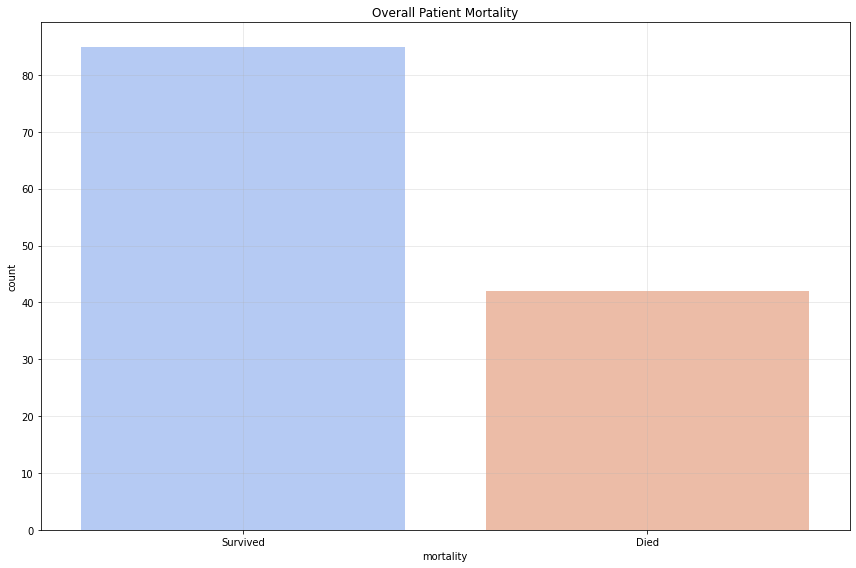

0      Survived
1          Died
2          Died
3      Survived
4          Died
         ...   
122    Survived
123    Survived
124    Survived
125    Survived
126    Survived
Name: mortality, Length: 127, dtype: object

In [0]:
# Plot 1: Overall Mortality
plt.figure(figsize=(12, 8))
sns.countplot(data=df_pd, x='mortality', palette='coolwarm')
plt.grid(alpha=0.3)
plt.title("Overall Patient Mortality")
plt.tight_layout()
plt.show()
display(df_pd['mortality'])

In [0]:
from pyspark.sql.functions import when, datediff, col

#age_at_death for patients who died
df = df.withColumn(
    "age_at_death",
    when(col("hospital_expire_flag") == 1, (datediff("admittime", "dob") / 365).cast("int"))
)

#update Pandas dataframe
df_pd = df.toPandas()

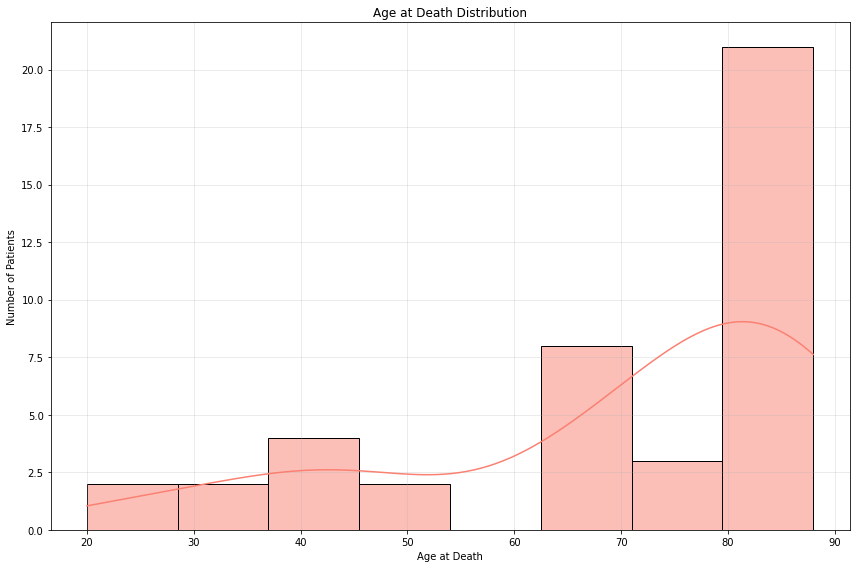

0       NaN
1      36.0
2      87.0
3       NaN
4      48.0
       ... 
122     NaN
123     NaN
124     NaN
125     NaN
126     NaN
Name: age_at_death, Length: 127, dtype: float64

In [0]:
# Plot2: Age at Death Distribution
plt.figure(figsize=(12, 8))
sns.histplot(data=df_pd[df_pd['age_at_death'].notna()], x='age_at_death', bins='auto', kde=True, color='salmon')
plt.grid(alpha=0.3)

plt.title("Age at Death Distribution")
plt.xlabel("Age at Death")
plt.ylabel("Number of Patients")
plt.tight_layout()
plt.show()

display(df_pd['age_at_death'])



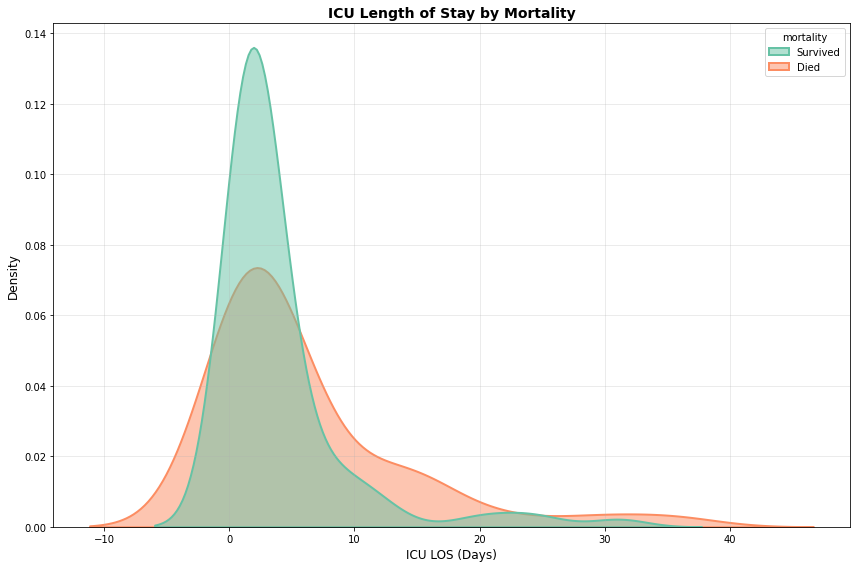

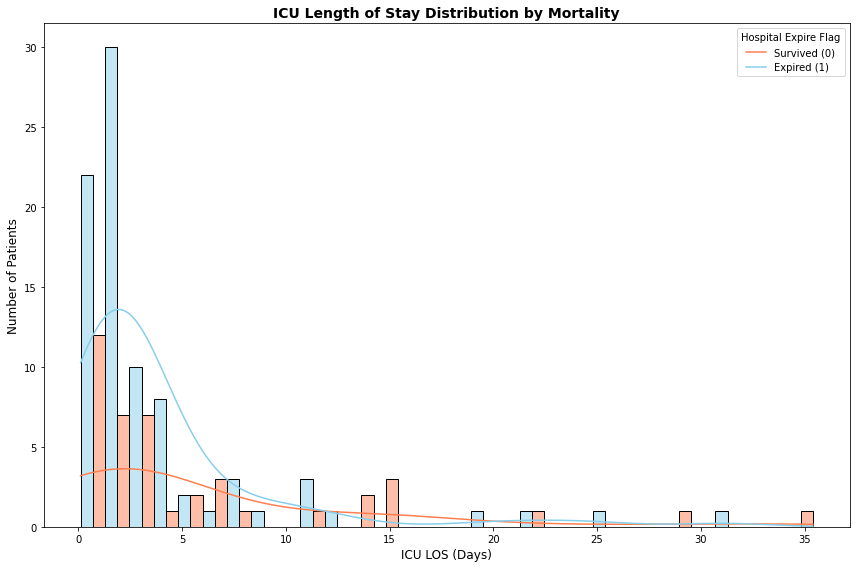

In [0]:
# Plot 3: ICU Length of Stay

plt.figure(figsize=(12, 8))
sns.kdeplot(
    data=df_pd,
    x="icu_los",
    hue="mortality",
    fill=True,
    common_norm=False,
    palette="Set2",
    alpha=0.5,
    linewidth=2
)

plt.title("ICU Length of Stay by Mortality", fontsize=14, fontweight='bold')
plt.xlabel("ICU LOS (Days)", fontsize=12)
plt.ylabel("Density", fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


# Plot 4: ICU Length of Stay by Mortality   

plt.figure(figsize=(12, 8))

sns.histplot(
    data=df_pd,
    x="icu_los",
    hue="hospital_expire_flag",
    multiple="dodge", 
    bins=30,
    kde=True,
    palette={0: "skyblue", 1: "coral"}
)

plt.title("ICU Length of Stay Distribution by Mortality", fontsize=14, fontweight="bold")
plt.xlabel("ICU LOS (Days)", fontsize=12)
plt.ylabel("Number of Patients", fontsize=12)
plt.legend(title="Hospital Expire Flag", labels=["Survived (0)", "Expired (1)"])
plt.tight_layout()
plt.show()


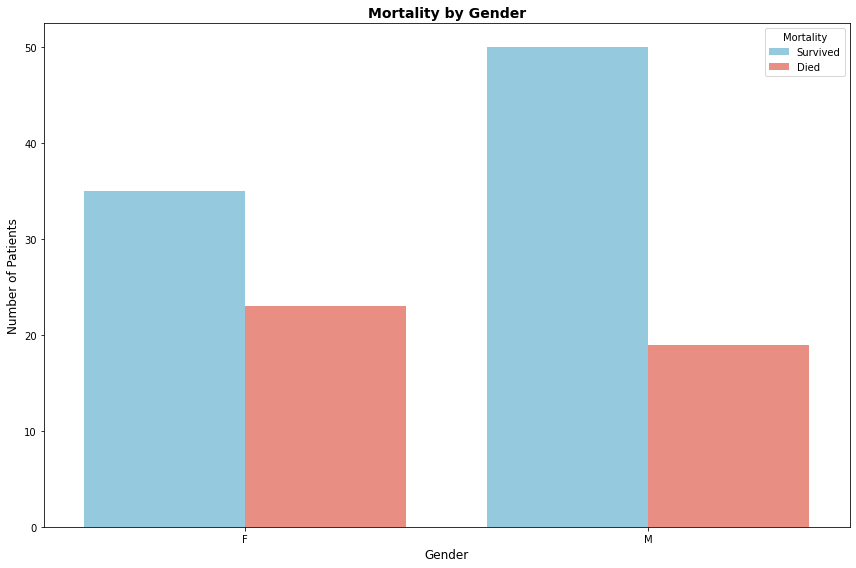

In [0]:
# Plot 5: Gender vs Mortality

palette = {
    "Survived": "skyblue",
    "Died": "salmon"
}


plt.figure(figsize=(12, 8))
sns.countplot(
    data=df_pd,
    x="gender",
    hue="mortality",
    palette=palette
)

plt.title("Mortality by Gender", fontsize=14, fontweight='bold')
plt.xlabel("Gender", fontsize=12)
plt.ylabel("Number of Patients", fontsize=12)
plt.legend(title="Mortality", labels=["Survived", "Died"])
plt.tight_layout()
plt.show()

In [0]:
from pyspark.sql.functions import datediff, to_date, col, when

admissions = admissions.withColumn("admittime", to_date("admittime"))
patients = patients.withColumn("dob", to_date("dob"))

#join and calculate age_at_death
patient_age_df = admissions.join(patients, on="subject_id", how="left") \
    .withColumn("age_at_death", when(col("hospital_expire_flag") == 1,
                                     (datediff(col("admittime"), col("dob")) / 365).cast("int")))


In [0]:
#Plot 6: Remove outliers > 30 days
deceased = deceased[deceased['time_to_death_days'] <= 30]

plt.figure(figsize=(12, 8))
sns.histplot(deceased['time_to_death_days'], bins=30, color='crimson', kde=True)
plt.title("Time of Death After Admission (<= 30 Days)")
plt.xlabel("Days Since Admission")
plt.ylabel("Number of Patients")
plt.tight_layout()
plt.show()

---------------------------------------------------------------------------
NameError                                 Traceback (most recent call last)
File <command-4185528301637865>:2
      1 #Plot 6: Remove outliers > 30 days
----> 2 deceased = deceased[deceased['time_to_death_days'] <= 30]
      4 plt.figure(figsize=(12, 8))
      5 sns.histplot(deceased['time_to_death_days'], bins=30, color='crimson', kde=True)

NameError: name 'deceased' is not defined

In [0]:
from pyspark.sql.functions import to_date, col, when, count, mean

#'admittime' and 'dob' to date format
admissions = admissions.withColumn("admittime", to_date("admittime"))
patients = patients.withColumn("dob", to_date("dob"))

#conv deathtime to date
df = df.withColumn("deathtime", to_date("deathtime"))

#create mortality_flag => 1 if deathtime is not null, else 0
df = df.withColumn("mortality_flag", when(col("deathtime").isNotNull(), 1).otherwise(0))

#group by insurance and calculate mortality rate
mortality_by_insurance = df.groupBy("insurance") \
    .agg(mean("mortality_flag").alias("mortality_rate")) \
    .withColumn("mortality_rate", (col("mortality_rate") * 100)) \
    .orderBy(col("mortality_rate").desc())

#convert to Pandas for plotting
mortality_by_insurance_pd = mortality_by_insurance.toPandas()


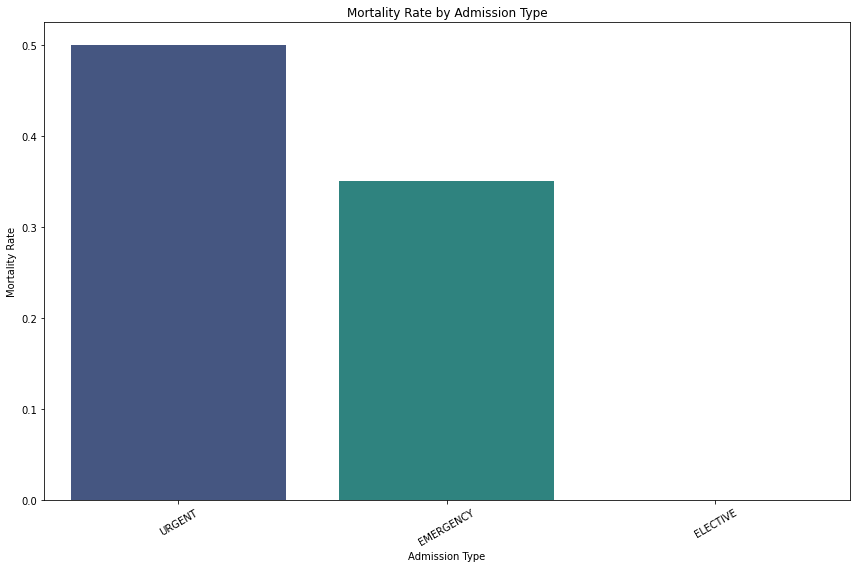

In [0]:
# Plot 7: Mortality by Admission Type
plt.figure(figsize=(12, 8))
adm_mortality = df_pd.groupby("admission_type")["hospital_expire_flag"].mean().sort_values(ascending=False)
sns.barplot(x=adm_mortality.index, y=adm_mortality.values, palette="viridis")
plt.title("Mortality Rate by Admission Type")
plt.xlabel("Admission Type")
plt.ylabel("Mortality Rate")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

In [0]:
replacements = {
    "Acute respiratory failure": "Respiratory Failure",
    "Pneumonia, organism unspecified": "Pneumonia",
    "Diabetes mellitus without mention of complication, type II or unspecified type, not stated as uncontrolled": "Type 2 Diabetes (No Complications)",
    "Severe sepsis": "Severe Sepsis",
    "Acute kidney failure, unspecified": "Acute Kidney Failure",
    "Unspecified septicemia": "Septicemia",
    "Other and unspecified hyperlipidemia": "Hyperlipidemia",
    "Atrial fibrillation": "Atrial Fibrillation",
    "Unspecified essential hypertension": "Hypertension",
    "Urinary tract infection, site not specified": "UTI",
    "Congestive heart failure, unspecified": "Heart Failure",
    "Unspecified acquired hypothyroidism": "Hypothyroidism",
    "Anemia, unspecified": "Anemia",
    "Long-term (current) use of anticoagulants": "Chronic Anticoagulant Use"
}

disease_mortality_pd["short_title"] = disease_mortality_pd["long_title"].replace(replacements)


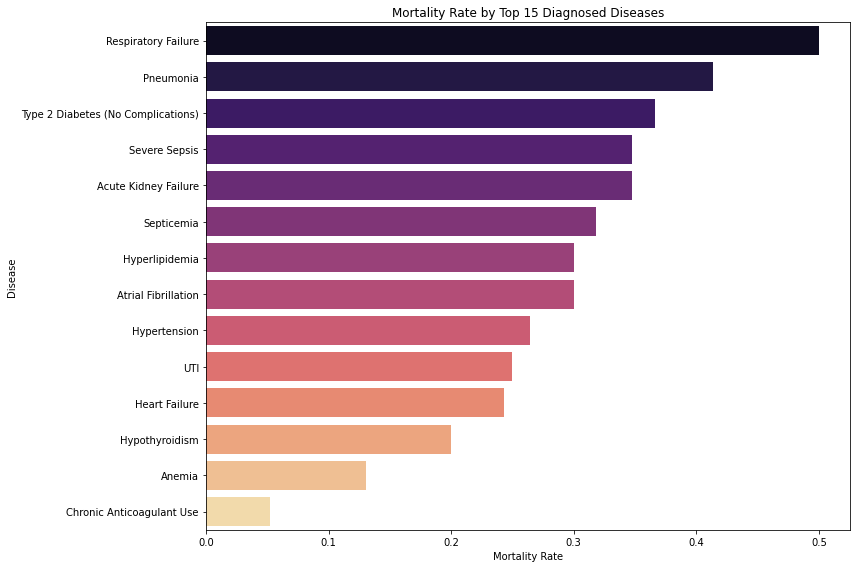

In [0]:
# Plot 8: Top 15 Disease Mortality Rates
plt.figure(figsize=(12, 8))
sns.barplot(data=disease_mortality_pd, x="mortality_rate", y="short_title", palette="magma")
plt.title("Mortality Rate by Top 15 Diagnosed Diseases")
plt.xlabel("Mortality Rate")
plt.ylabel("Disease")
plt.tight_layout()
plt.show()


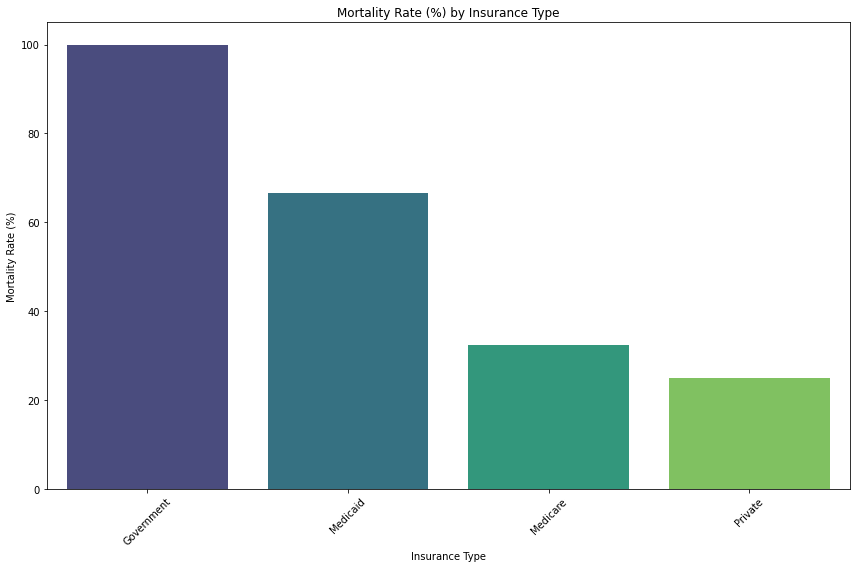

    insurance  mortality_rate
0  Government      100.000000
1    Medicaid       66.666667
2    Medicare       32.291667
3     Private       25.000000


In [0]:
# Plot 9: Mortality Rate (%) by Insurance Type
plt.figure(figsize=(12, 8))
sns.barplot(data=mortality_by_insurance_pd, x='insurance', y='mortality_rate', palette='viridis')
plt.title('Mortality Rate (%) by Insurance Type')
plt.xlabel('Insurance Type')
plt.ylabel('Mortality Rate (%)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print(mortality_by_insurance_pd.head())


In [0]:
#Plot 10: Hour of Admission vs Mortality Rate
hourly_mortality = admissions.groupby('hour')['hospital_expire_flag'].mean()

plt.figure(figsize=(12, 8))
sns.lineplot(x=hourly_mortality.index, y=hourly_mortality.values, marker='o', color='tomato')
plt.title("Mortality Rate by Hour of Admission")
plt.xlabel("Hour of Day (0–23)")
plt.ylabel("Mortality Rate")
plt.xticks(range(0, 24))
plt.grid(True)
plt.tight_layout()
plt.show()

---------------------------------------------------------------------------
TypeError                                 Traceback (most recent call last)
File <command-4185528301637870>:2
      1 #Plot 10: Hour of Admission vs Mortality Rate
----> 2 hourly_mortality = admissions.groupby('hour')['hospital_expire_flag'].mean()
      4 plt.figure(figsize=(12, 8))
      5 sns.lineplot(x=hourly_mortality.index, y=hourly_mortality.values, marker='o', color='tomato')

TypeError: 'GroupedData' object is not subscriptable

<command-4185528301637877>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vitals['charttime'] = pd.to_datetime(vitals['charttime'])


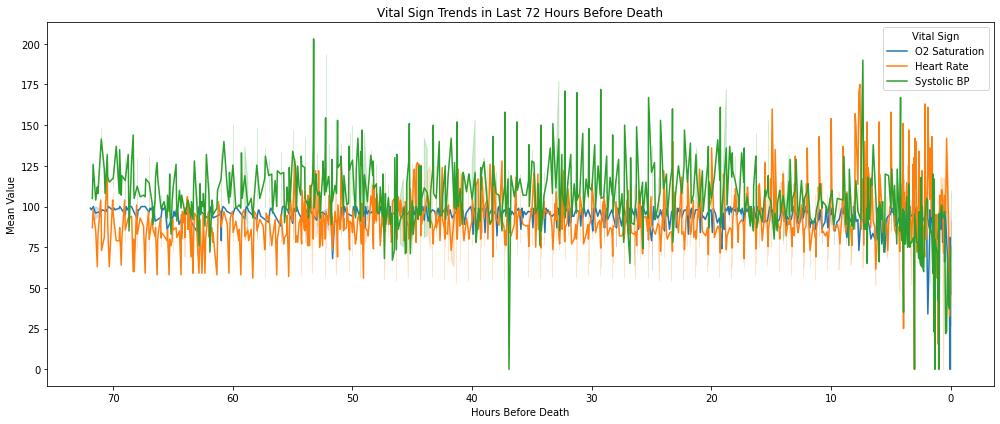

In [0]:
# Plot 11: Trends in 72 hours before death

# Use Spark to read
admissions_spark = spark.read.option("header", "true").option("inferSchema", "true") \
    .option("timestampFormat", "yyyy-MM-dd HH:mm:ss") \
    .csv("dbfs:/FileStore/tables/ADMISSIONS.csv")

chartevents_spark = spark.read.option("header", "true").option("inferSchema", "true") \
    .csv("dbfs:/FileStore/tables/CHARTEVENTS.csv")

# Convert to pandas
admissions2 = admissions_spark.toPandas()
chartevents2 = chartevents_spark.toPandas()

# Continue with your analysis
vitals_map = {
    'Heart Rate': 211,
    'Systolic BP': 51,
    'O2 Saturation': 220277
}

vitals = chartevents2[chartevents2['itemid'].isin(vitals_map.values())]
vitals['charttime'] = pd.to_datetime(vitals['charttime'])
admissions2['deathtime'] = pd.to_datetime(admissions2['deathtime'])

admissions2['mortality'] = admissions2['hospital_expire_flag']
vitals = vitals.merge(admissions2[['subject_id', 'hadm_id', 'mortality', 'deathtime']], on=['subject_id', 'hadm_id'], how='inner')
vital_death = vitals[vitals['mortality'] == 1].copy()
vital_death['hours_before_death'] = (vital_death['deathtime'] - vital_death['charttime']).dt.total_seconds() / 3600
vital_death = vital_death[(vital_death['hours_before_death'] >= 0) & (vital_death['hours_before_death'] <= 72)]

id_to_label = {v: k for k, v in vitals_map.items()}
vital_death['Vital Sign'] = vital_death['itemid'].map(id_to_label)

plt.figure(figsize=(14, 6))
sns.lineplot(data=vital_death, x='hours_before_death', y='valuenum', hue='Vital Sign', estimator='mean')
plt.gca().invert_xaxis()
plt.title("Vital Sign Trends in Last 72 Hours Before Death")
plt.xlabel("Hours Before Death")
plt.ylabel("Mean Value")
plt.tight_layout()
plt.show()